In [3]:
import numpy as np
import glob
import os
import importlib
import yaml
import albumentations
import glob
import json
import torch
import cv2
import matplotlib.pyplot as plt
from skimage.io import imread, imsave
from PIL import Image
from torch.utils.data import random_split, DataLoader, Dataset
from omegaconf import OmegaConf
from tqdm.notebook import tqdm
from taming.modules.util import box_mask, BatchRandomMask

import warnings
warnings.filterwarnings("ignore", category=UserWarning) 

def imshow(images, titles=None, save_path=None):
    n_img = len(images)
    plt.rcParams['figure.figsize'] = [4*n_img, 4*n_img]
    
    if n_img > 1:
        fig, ax = plt.subplots(1, n_img)
        for i in range(n_img):
            if titles is not None and i < len(titles):
                ax[i].set_title(titles[i])
            ax[i].axis('off')
            ax[i].imshow(images[i])
    else:
        if titles is not None:
            plt.set_titile(titles[0])
        plt.axis('off')
        plt.imshow(images[0])

    if save_path is not None:
        plt.savefig(save_path)

def center_crop(image, s=512):
    h, w = image.shape[:2]
    if s > h or s > w:
        image = rescale(image, s/min(h,w), anti_aliasing=True)
        image = (image * 255).astype(np.uint8)
        h, w = image.shape[:2]
    ih = (h - s) // 2   
    iw = (w - s) // 2
    return image[ih:ih+s, iw:iw+s]

# load a single input
def preprocess(x, res=512, normalize=True):
    if normalize:
        x = x.transpose(2,0,1)
        x = (torch.from_numpy(x).float().to(device) / 127.5 - 1).unsqueeze(0)
    else:
        x = torch.from_numpy(x).float().to(device).unsqueeze(0)
    return torch.nn.functional.interpolate(x, size=(res,res))
    
def to_img(x):
    x = (x.permute(0, 2, 3, 1) * 127.5 + 127.5).round().clamp(0, 255).to(torch.uint8)
    return x[0].detach().cpu().numpy()

def readmask(path):
    mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0
    return mask

# validation input
# places_val_files = glob.glob("/home/ICT2000/chenh/Haiwei/Datasets/Places365/val_large/*.jpg")
places_val_files = glob.glob("/home/chenh/data/val_large/*.jpg")

# images = [center_crop(imread(f)) for f in places_val_files[k:k+3]]
# imshow(images)

# validation results (MAT)
places_val_files.sort()
image_names = [os.path.basename(p).replace('jpg', 'png') for p in places_val_files]

# preds = [imread(os.path.join(MAT_rstfolder, n)) for n in image_names]
# imshow(preds)

# mask folder
maskfolder = "/home/chenh/data/masks_val_512_eval"
ids = [im[-10:-4] for im in image_names]

# masks = [readmask(os.path.join(maskfolder, f"{id}.png")) for id in ids]
# imshow(masks)

def get_data(k, res, p=None):
    if p is None:
        p = places_val_files[k]                 
    gt = center_crop(imread(p))
    if len(gt.shape) == 2:
        gt = np.repeat(gt[...,None], 3, axis=2) 
    gt = preprocess(gt, res)
    try:
        mask_in = preprocess(readmask(os.path.join(maskfolder, f"{ids[k]}.png"))[None], res,normalize=False)
    except Exception:
        return gt, None
    return gt, mask_in


current_dir = os.path.abspath('.')
current_dir


'/home/chenh/taming-transformers'

In [ ]:
os.chdir(current_dir)

# Test dataloader (optional)
def get_obj_from_str(string, reload=False):
    module, cls = string.rsplit(".", 1)
    if reload:
        module_imp = importlib.import_module(module)
        importlib.reload(module_imp)
    return getattr(importlib.import_module(module, package=None), cls)

def instantiate_from_config(config):
    if not "target" in config:
        raise KeyError("Expected key `target` to instantiate.")
    return get_obj_from_str(config["target"])(**config.get("params", dict()))

# load config for transformer
config_path = "configs/places_decoder.yaml"
config = OmegaConf.load(config_path)
config['data']['params']['batch_size'] = 1
config['data']['params']['test']['params']['crop_size'] = 512
config['data']['params']['test']['params']['rescale_size'] = 512

data = instantiate_from_config(config.data)
data.prepare_data()
data.setup()
dataset = data.datasets['test']


In [ ]:
test_path = '/home/ICT2000/chenh/Haiwei/Datasets/Places365/test_large/Places365_test_00195819.jpg'

In [ ]:
# Loading MAT network models
MAT_folder = "/home/ICT2000/chenh/Haiwei/MAT/MAT"
os.chdir(MAT_folder)
from networks.mat import Generator
import dnnlib
import legacy

ckpt_path = "models/Places_512.pkl" # Places_512_FullData.pkl
device = torch.device('cuda:1')
with dnnlib.util.open_url(ckpt_path) as f:
    G_saved = legacy.load_network_pkl(f)['G_ema'].to(device).eval().requires_grad_(False) # type: ignore

def named_params_and_buffers(module):
    assert isinstance(module, torch.nn.Module)
    return list(module.named_parameters()) + list(module.named_buffers())


def copy_params_and_buffers(src_module, dst_module, require_all=False):
    assert isinstance(src_module, torch.nn.Module)
    assert isinstance(dst_module, torch.nn.Module)
    src_tensors = {name: tensor for name, tensor in named_params_and_buffers(src_module)}
    for name, tensor in named_params_and_buffers(dst_module):
        assert (name in src_tensors) or (not require_all)
        if name in src_tensors:
            tensor.copy_(src_tensors[name].detach()).requires_grad_(tensor.requires_grad)

net_res = 512
G = Generator(z_dim=512, c_dim=0, w_dim=512, img_resolution=net_res, img_channels=3).to(device).eval().requires_grad_(False)
copy_params_and_buffers(G_saved, G, require_all=True)
    

In [ ]:
# Evaluation with the MAT pretrained model
with torch.no_grad():
    k = 42
    res = 512
    
    gt = preprocess(center_crop(imread(places_val_files[k])), res)
    # gt = preprocess(center_crop(imread(test_path)), res)
    
    # batch = dataset[16]
    # gt = torch.from_numpy(batch['image'][None]).to(device)
    # gt = gt.permute(0, 3, 1, 2).to(memory_format=torch.contiguous_format)

    x = gt
    
    mask_in = preprocess(readmask(os.path.join(maskfolder, f"{ids[k]}.png"))[None], res,normalize=False)

    #############################
    mask = box_mask(x.shape, x.device, 0.8, det=True).float()
    mask_in = torch.round(mask).to(device)
    ##################################
    
    # pred_ref = preprocess(imread(os.path.join(MAT_rstfolder, image_names[k])), res)
    x_in = gt * mask_in

    # inference with MAT network models

    # no Labels.
    label = torch.zeros([1, G.c_dim], device=device)
    z = torch.from_numpy(np.random.randn(1, G.z_dim)).to(device)
    output = G(x_in, mask_in, z, label, truncation_psi=1, noise_mode='const')
    output = (output.permute(0, 2, 3, 1) * 127.5 + 127.5).round().clamp(0, 255).to(torch.uint8)
    output_mat = output[0].detach().cpu().numpy()

imshow([to_img(x_in), output_mat], titles=['input','pred'])

In [2]:
# loading our model
os.chdir(current_dir)

from omegaconf import OmegaConf
import yaml
import torch.nn.functional as F
import importlib
from torch.utils.data import random_split, DataLoader, Dataset

def instantiate_from_config(config):
    if not "target" in config:
        raise KeyError("Expected key `target` to instantiate.")
    return get_obj_from_str(config["target"])(**config.get("params", dict()))


def get_obj_from_str(string, reload=False):
    module, cls = string.rsplit(".", 1)
    if reload:
        module_imp = importlib.import_module(module)
        importlib.reload(module_imp)
    return getattr(importlib.import_module(module, package=None), cls)

device = torch.device('cuda:4')
config_path = "configs/places_inpainting_largebox.yaml"
config = OmegaConf.load(config_path)
config['data']['params']['batch_size'] = 1
config['model']['params']['encoder_config']['params']['ddconfig']['clamp_ratio'] = 0.25

model = instantiate_from_config(config.model).to(device)

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
Restored from logs/ckpts/places256_vqgan1024_BASE.ckpt
Restored from logs/ckpts/2023-05-26T15-25-34_places256_partialencoder_1024_cont.ckpt
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.
Restored from logs/2023-10-05T19-44-28_styleGAN_decoder_large_mask/checkpoints/last.ckpt
Restored from logs/ckpts/maskgit_ly40.ckpt
Using no cond stage. Assuming the training is intended to be unconditional. Prepending 0 as a sos token.
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
Restored from logs/2023-10-21T02-48-27_places_beta_unet/checkpoints/last.ckpt


In [ ]:
# optional: using dataloader 
data = instantiate_from_config(config.data)
data.prepare_data()
data.setup()
dataset = data.datasets['test']
batch = dataset[0]
batch['mask'].shape

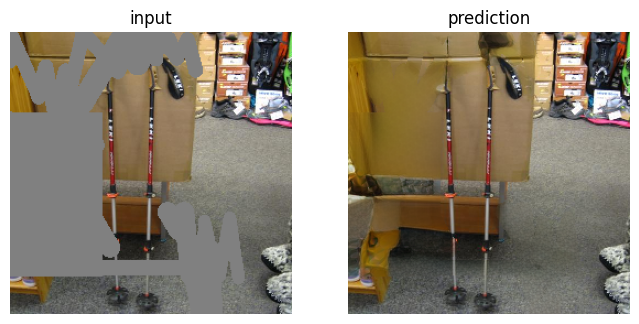

In [411]:
from taming.modules.util import scatter_mask, box_mask, mixed_mask, BatchRandomMask
import time
from skimage.transform import rescale, resize, downscale_local_mean

def get_data(k, res, p=None):
    if p is None:
        p = places_val_files[k]                 
    gt = center_crop(imread(p))
    if len(gt.shape) == 2:
        gt = np.repeat(gt[...,None], 3, axis=2) 
    gt = preprocess(gt, res)
    try:
        mask_in = preprocess(readmask(os.path.join(maskfolder, f"{ids[k]}.png"))[None], res,normalize=False)
    except Exception:
        return gt, None
    return gt, mask_in


# examplar: 41, 922

# 4843 (dec), 2421 (dec), 717 (git), 2376 (git), 37 (dec)

# 28 (dec), 34 (git)

# batch = dataset[0]
# print(batch['filename_'])

def center_crop(image, s=512):
    h, w = image.shape[:2]
    if s > h or s > w:
        image = rescale(image, s/min(h,w), anti_aliasing=True)
        image = (image * 255).astype(np.uint8)
        h, w = image.shape[:2]
    ih = (h - s) // 2   
    iw = (w - s) // 2
    return image[ih:ih+s, iw:iw+s]

'''
candidate settings : 
1) 0.33 ratio, 0.8 degrad, 1.0t, no topk (more error prone)
2) 0.1 ratio, 0.95 degrad. 1.0t, no topk
3) 0.2 ratio, 0.9 degrad, 1.0t, 50 topk (default)


'''
def forward_to_indices(model, batch, z_indices, mask):
    x, c = model.get_xc(batch)
    x = x.to(device=device).float()
    c = c.to(device=device).float()
    quant_c, c_indices = model.encode_to_c(c)
    mask = model.preprocess_mask(mask, z_indices)
    r_indices = torch.full_like(z_indices, model.mask_token)
    z_start_indices = mask*z_indices+(1-mask)*r_indices      
    index_sample, probs, candidates = model.sample(z_start_indices.to(device=device), 
                               c_indices.to(device=device),
                               sampling_ratio=0.2,
                               temperature = 1.0,
                               sample=True,
                               temperature_degradation=0.9,
                               top_k=None,
                               return_probs = True,
                               scheduler = 'cosine',
                              )
    return index_sample, probs, candidates

 
k = 188
    
# src = '/home/chenh/data/val_large/Places365_val_00010691.jpg'


with torch.no_grad():
    # gt = torch.from_numpy(batch['image'].transpose(2,0,1)).unsqueeze(0).to(device)
    # mask = torch.from_numpy(batch['mask'].transpose(2,0,1)).unsqueeze(0).to(device)
    gt, mask = get_data(indices[8], 256)
    x = gt.to(device)
    
    #############################
    # mask = box_mask(x.shape, x.device, 0.8, det=True).float()
    # mask = torch.from_numpy(BatchRandomMask(x.shape[0], x.shape[-1], hole_range=[0.0,0.5])).to(x.device)
    #     for i in range(200):
    #         bmask = box_mask(x.shape, x.device, 0.05, det=False).float()
    #         mask = torch.logical_and(mask, bmask).float()
    ##################################
    mask = torch.round(mask).to(device)
    
    VQModel, Encoder, Transformer, Unet = model.helper_model
    VQModel = VQModel.to(device)
    Encoder = Encoder.to(device)
    Transformer = Transformer.to(device)

    gt_quant_z, _, _ = VQModel.encode(x)

    start_encoder = time.time()
    quant_z, _, info, mask_out = Encoder.encode(x*mask, mask)
    mask_out = mask_out.reshape(x.shape[0], -1)
    z_indices = info[2].reshape(x.shape[0], -1)
    batch = {'image': (x*mask).permute(0,2,3,1)}
    end_encoder = time.time()
    z_indices_complete, probs, candidates = forward_to_indices(Transformer, batch, z_indices, mask_out)
    end_transformer = time.time()
    B, C, H, W = quant_z.shape
    quant_z_complete = VQModel.quantize.get_codebook_entry(z_indices_complete.reshape(-1).int(), shape=(B, H, W, C))

    # quant_z_complete = gt_quant_z
    
    # mask_out_interpolate = F.interpolate(mask, (16,16)).reshape(x.shape[0], -1)
    
    # rec, _, _, quant_z, _, _ = model(batch, recomposition=True, mask=mask, simple_return=False)
    # rec_fstg = VQModel.decode(quant_z)

    rec_fstg = VQModel.decode(quant_z_complete)
    
    dec, _, mout, f0, f1 = model.current_model(batch, 
                                quant=quant_z_complete, 
                                mask_in=mask, 
                                mask_out=mask_out.reshape(B, 1, H, W),
                                return_fstg=False, debug=True)  
    rec = x * mask + dec * (1-mask) 

    if Unet is not None:
        Unet = Unet.to(device)
        rec = Unet.refine(rec, mask)
    end_decoder = time.time()

# t1 = end_encoder-start_encoder
# t2 = end_transformer-end_encoder
# t3 = end_decoder-end_transformer
# print("Encoder Inference speed:", t1,'s')
# print("Transformer Inference speed:", t2,'s')
# print("Decoder Inference speed:", t3,'s')
# print("All:", t1+t2+t3, 's')

mask_int = F.interpolate(F.interpolate(mask, size=(16,16), mode='nearest'),(256,256))
mask_out_int = F.interpolate(mask_out.reshape(1,1,16,16),(256,256))

# imshow([to_img(x*mask), to_img(rec_fstg)])
imshow([to_img(x*mask), to_img(rec)], titles=['input', 'prediction'])
# imsave(f'logs/eval/{k}.png', to_img(rec))
# print((1-mout).sum(), torch.sum((f1[0]**2).sum(0).reshape(-1)) / (1-mout).sum())

In [204]:
print([1 * (0.8**k) for k in range(3)])
print([1 * (0.96**k) for k in range(10)])
print([1 * (0.84**k) for k in range(5)])

[1.0, 0.8, 0.6400000000000001]
[1.0, 0.96, 0.9216, 0.8847359999999999, 0.8493465599999999, 0.8153726975999999, 0.7827577896959999, 0.7514474781081598, 0.7213895789838334, 0.69253399582448]
[1.0, 0.84, 0.7055999999999999, 0.5927039999999999, 0.49787135999999993]


In [368]:
# group eval
from tqdm.notebook import trange, tqdm

ratios = []
indices = []
for k in trange(1000):
    gt, mask = get_data(k, 256)
    r = mask.sum().item()/ gt.shape[-1]**2
    ratios.append(r)
    if r > 0.6:
        indices.append(k)

  0%|          | 0/1000 [00:00<?, ?it/s]

39


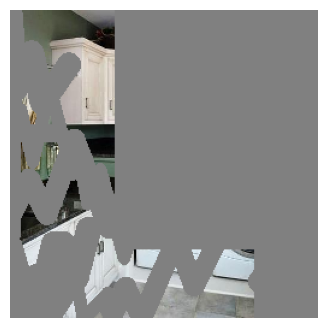

In [33]:
gt, mask = get_data(indices[3], 256)
print(len(indices))
imshow([to_img(gt*mask)])


In [ ]:
with torch.no_grad():
    all_probs = np.concatenate([p.reshape(-1) for p in probs])
    all_cands = np.concatenate([c.reshape(-1) for c in candidates])
    replace = all_cands[np.argsort(all_probs)[100:]]

    z_indices_complete[0,replace] = 0
    mask_out_2 = (z_indices_complete != 0).float()
    
    z_indices_complete, _, _ = forward_to_indices(Transformer, batch, z_indices_complete.int(), mask_out_2)
    B, C, H, W = quant_z.shape
    quant_z_complete = VQModel.quantize.get_codebook_entry(z_indices_complete.reshape(-1).int(), shape=(B, H, W, C))
    rec_fstg = VQModel.decode(quant_z_complete)
    dec, _ = model.current_model(batch, 
                            quant=quant_z_complete, 
                            mask_in=mask,
                            mask_out=mask_out.reshape(B, 1, H, W),
                            return_fstg=False,
                            debug=False)
    
    rec2 = x * mask + dec * (1-mask) 
    imshow([to_img(x*mask), to_img(rec), to_img(rec2)])

In [ ]:
ps = [p.reshape(-1) for p in probs]
cs = [c.reshape(-1) for c in candidates]

canvas = np.zeros([16**2,3])
canvasB = np.zeros([16**2,3])
step = 0
for p, c in zip(ps,cs):
    for p0, c0 in zip(p,c):
        canvas[c0,0] = 1.0
        canvasB[c0,0] = p0
    if step >= end:
        break
    step += 1
        
canvas = (canvas * 255).astype(np.uint8) 
canvas = canvas.reshape(16,16,3)
canvasB = (canvasB * 255).astype(np.uint8) 
canvasB = canvasB.reshape(16,16,3)
end += 1
imshow([canvas, canvasB])

In [ ]:
# imshow([to_img(x*mask),to_img(x*mask_out), to_img(rec_fstg), to_img(rec)])
print(np.unique(mask_int.detach().cpu().numpy()))
imshow([to_img(x*mask), to_img(x*mask_out_int), to_img(x*(mask_int>0.25))])


In [ ]:
with torch.no_grad():
    gt_quant_z, _, _ = VQModel.encode(x)
    m = mask_out.reshape(1,1,16,16)
    quant_compose = (1-m) * gt_quant_z + m * quant_z
    rec_gt = VQModel.decode(gt_quant_z)
    rec_cls = VQModel.decode(quant_compose)

imshow([to_img(rec_gt), to_img(rec_cls)])

In [ ]:
@torch.no_grad()
def predict(gt, mask, m):
    x = gt.to(device)
    mask_in = mask.to(device)
    batch = {'image': gt.permute(0,2,3,1)}
    rec, _ = m(batch, recomposition=False, mask=mask_in, simple_return=True)

    # linear blending
    k = 3
    kernel = torch.ones(1,1,k,k) / k**2
    pad = k // 2
    smoothed_mask = F.conv2d(F.pad(mask_in,(pad,pad,pad,pad),value=1), kernel.to(mask_in.device), bias=None, padding=0)
    smoothed_mask = mask_in
    
    # composition
    rec = smoothed_mask * gt + (1 - smoothed_mask) * rec
    return rec

gt, mask = get_data(4, 256)
rst = predict(gt, mask, model)
imshow([to_img(gt*mask), to_img(rst)], titles=['input','pred'])

In [ ]:
# pyramid blending? doesn't seem to work...
import cv2 as cv

A = to_img(x*mask)
B = to_img(rec)
M = mask[0].permute(1,2,0).detach().cpu().numpy().astype(np.uint8)

# generate Gaussian pyramid for A
G = A.copy()
gpA = [G]
for i in range(6):
 G = cv.pyrDown(G)
 gpA.append(G)
    
# generate Gaussian pyramid for B
G = B.copy()
gpB = [G]
for i in range(6):
 G = cv.pyrDown(G)
 gpB.append(G)
    
# generate Laplacian Pyramid for A
lpA = [gpA[5]]
for i in range(5,0,-1):
 GE = cv.pyrUp(gpA[i])
 L = cv.subtract(gpA[i-1],GE)
 lpA.append(L)
    
# generate Laplacian Pyramid for B
lpB = [gpB[5]]
for i in range(5,0,-1):
 GE = cv.pyrUp(gpB[i])
 L = cv.subtract(gpB[i-1],GE)
 lpB.append(L)
    
# Now add left and right halves of images in each level
LS = []
for la,lb in zip(lpA,lpB):
 rows,cols,dpt = la.shape
 currM = cv2.resize(M,la.shape[:2]).astype(np.uint8)[...,None]
 ls = currM * la + (1-currM) * lb
 LS.append(ls)
# now reconstruct
ls_ = LS[0]
for i in range(1,6):
 ls_ = cv.pyrUp(ls_)
 ls_ = cv.add(ls_, LS[i])

imshow([B, M * A + (1-M) * ls_])